# Circular habitat uniform

**authors:** Joseph Marcus
 
Here I simulate genetic data under the coalescent in a circular habitat and explore the fit of different ways to compute expected genetic distances on simulated genotypes. 

Lets load the necessary packages and modules to get started 

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("../code/")
from habitat import *
from genotype_simulator import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Plot size configuration 

In [3]:
sns.set_style('white')
plt.style.use('bmh')
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = 8, 6

## Setup the habitat

Here we define a circular habitat with 64 demes in total 

In [4]:
d = 64
hab = Circle(d)

Next we need to define a migration surface which is a function on the nodes of the graph that define edge weights. Here i just set all migration rates uniformly

In [5]:
def uniform_migration(self):
    """            
    Returns:
        g: nx.graph
            regular lattice with assigned weights
    """
    for i,j in self.g.edges():
        self.g[i][j]['m'] = 1.
        
    self.m = nx.adjacency_matrix(self.g, weight='m')
    self.m = self.m.toarray()
    
    # normalize to sum to 1
    self.m = self.m / np.sum(self.m, axis=1, keepdims=True)

We then assign this method to the habitat object

In [6]:
# assign the migration method
hab.migration_surface = uniform_migration

# create the migration matrix
hab.migration_surface(hab)

# compute graph laplacian
hab.get_graph_lapl()

Lets visualize the circular habitat with edge widths proportional to the defined edge weights, note we multiply the weights by some constant just for visualization purposes. Additionally, the nodes have a color scheme based on their position on the map, particularly the x position difference is emphasized more than the y the habitat which as not as informative in the circular habitat but useful for grid based simulations. As expected, we see edges weights are all the same

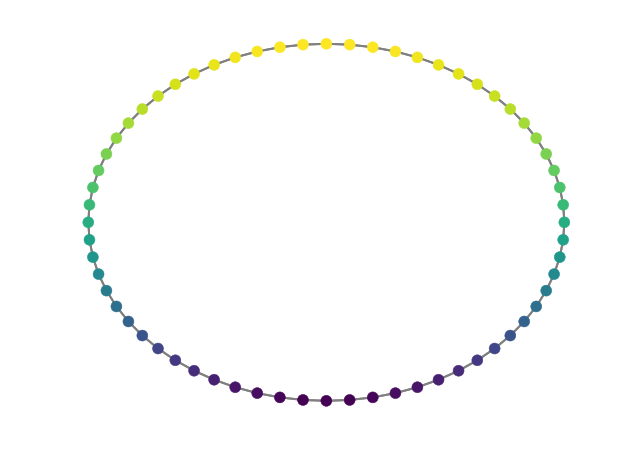

In [7]:
hab.plot_habitat(120, 2, False)

As expected we see that the migration matrix $\mathbf{M}$ is extremely sparse as only neighboring nodes are connected. Each node only has two neighbors!

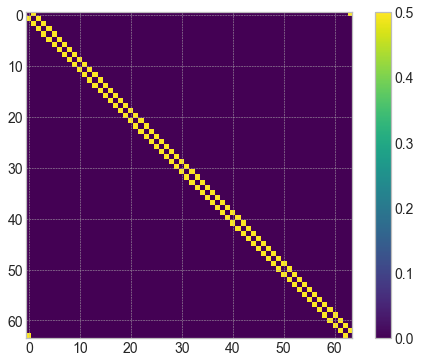

In [8]:
hab.plot_migration_matrix()

## Simulate genotypes

Here we simulate genotypes under the coalescent using msprime ... this may take a bit of time. Specifically we simulate 10 haploid individuals per deme in 5000 independent regions of the genome. See `../code/genotype_simulator.py` for default params and implementation of the simulation object.

In [20]:
sim_path = path = "../output/simulations/cir_unif.pkl"
geno = GenotypeSimulator(hab, sim_path, n_rep=5e3)

print(geno.y.shape)

(640, 19977)


Here we visualize the site frequency spectrum which seems to have a slight an enrichment of common variants suggesting a divergence from the neutral expectation which is true as we are simulating a structured population!

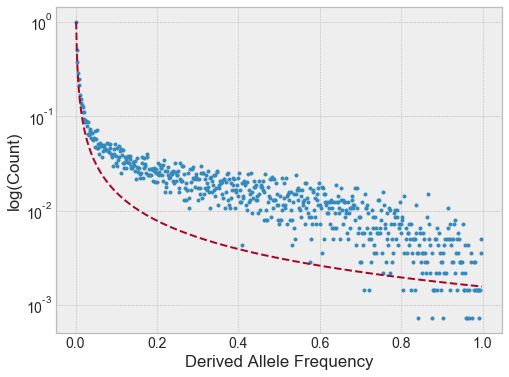

In [21]:
geno.plot_sfs()

Lets filter out too rare variants leavings us with fewer SNPs

In [11]:
geno.filter_rare_var()

print(geno.y.shape)

(640, 13135)


Lets perform PCA on the genotype matrix and visualize the first two PCs. Note that I center and scale the data matrix before running PCA.

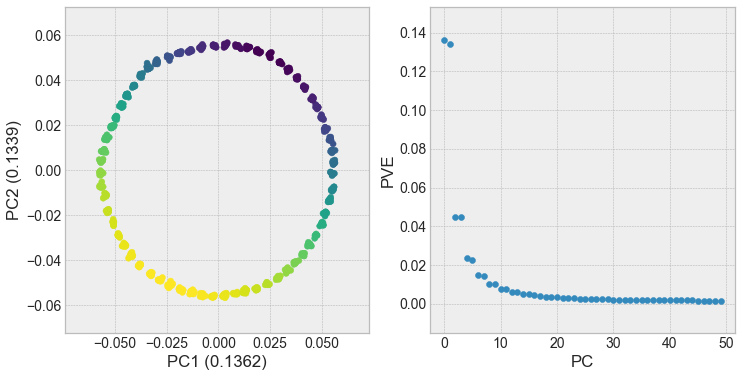

In [22]:
geno.pca()
geno.plot_pca(geno.pcs, geno.pves)

Wow PCA and strongly recapitulates population structure here!

## Expected genetic distances

We can see the graph laplacian is sparse as $\mathbf{M}$ is sparse. We can think of $\mathbf{L}$ here as a sparse precision matrix

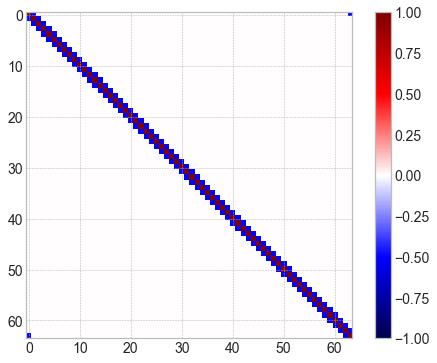

In [23]:
hab.plot_precision_matrix(hab.l)

We can see that $\mathbf{L}\mathbf{L}^T$ is also sparse but not as sparse. It seems to have an additional off-diagonal band

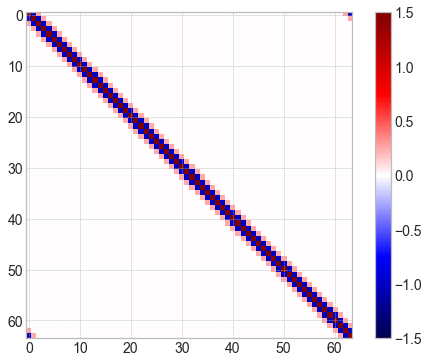

In [24]:
hab.plot_precision_matrix(hab.l @ hab.l.T)

Compute observed genetic distances and different models to compute expected genetic distances. Note that I center the data matrix before computing genetic distances but I do not scale.

In [25]:
# lower triangular indicies
tril_idx = np.tril_indices(geno.n, -1)

# observed genetic distance
d_geno = geno.geno_dist()
d_geno_tril = d_geno[tril_idx]

# geographic distance
d_geo = geno.node_to_obs_mat(hab.geo_dist(), geno.n, geno.v)
d_geo_tril = d_geo[tril_idx]

# resistence distance
d_res = geno.node_to_obs_mat(hab.rw_dist(hab.l), geno.n, geno.v)
d_res_tril = d_res[tril_idx]

# random-walk distance
d_rw = geno.node_to_obs_mat(hab.rw_dist(hab.l @ hab.l.T), geno.n, geno.v)
d_rw_tril = d_rw[tril_idx]

coal r2 = 0.9661125690153836


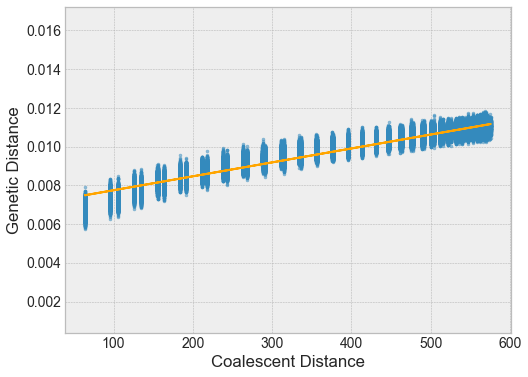

In [26]:
# coalescent distance
d_coal = geno.node_to_obs_mat(hab.coal_dist(), geno.n, geno.v)
d_coal_tril = d_coal[tril_idx]

geno.plot_dist(d_coal_tril, d_geno_tril, "Coalescent Distance", "Genetic Distance")
print('coal r2 = {}'.format(np.corrcoef(d_coal_tril, d_geno_tril)[0, 1]))

geo r2 = 0.9554457423695474


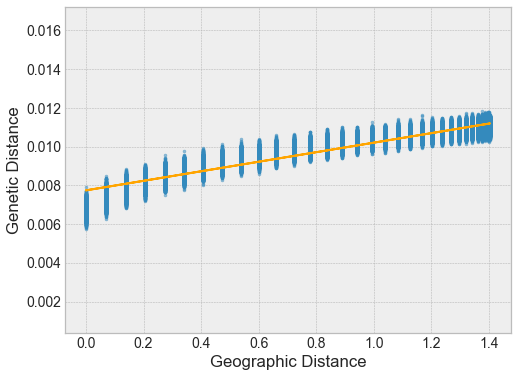

In [27]:
geno.plot_dist(d_geo_tril, d_geno_tril, "Geographic Distance", "Genetic Distance")

print('geo r2 = {}'.format(np.corrcoef(d_geo_tril, d_geno_tril)[0, 1]))

res r2 = 0.9653913074460693


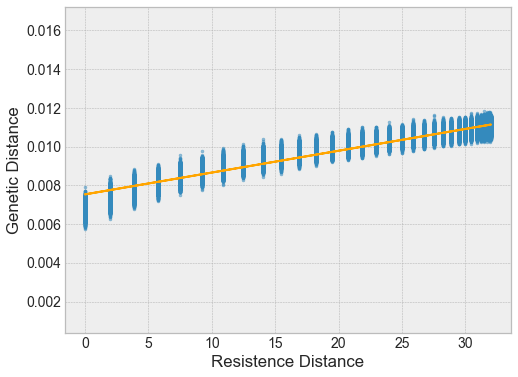

In [28]:
geno.plot_dist(d_res_tril, d_geno_tril, "Resistence Distance", "Genetic Distance")

print('res r2 = {}'.format(np.corrcoef(d_res_tril, d_geno_tril)[0, 1]))

rw r2 = 0.9092096435345359


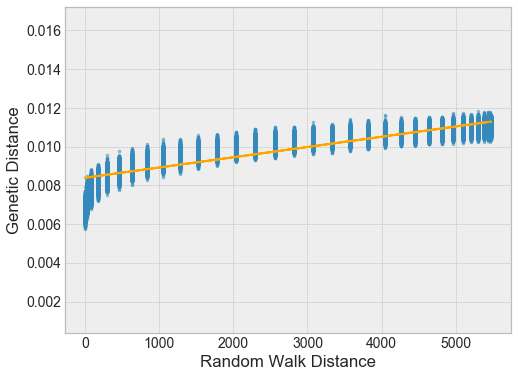

In [29]:
geno.plot_dist(d_rw_tril, d_geno_tril, "Random Walk Distance", "Genetic Distance")
print('rw r2 = {}'.format(np.corrcoef(d_rw_tril, d_geno_tril)[0, 1]))

In summary ...

In [30]:
print('coal r2 = {}'.format(np.corrcoef(d_coal_tril, d_geno_tril)[0, 1]))
print('geo r2 = {}'.format(np.corrcoef(d_geo_tril, d_geno_tril)[0, 1]))
print('res r2 = {}'.format(np.corrcoef(d_res_tril, d_geno_tril)[0, 1]))
print('rw r2 = {}'.format(np.corrcoef(d_rw_tril, d_geno_tril)[0, 1]))

coal r2 = 0.9661125690153836
geo r2 = 0.9554457423695474
res r2 = 0.9653913074460693
rw r2 = 0.9092096435345359


Interestingly, in this case the random-walk distance computed using $\mathbf{L}\mathbf{L}^T$ seems to have a worse fit compared to both geographic distance and resistance distance which should match exactly the coalescent model I simulate under. 

*I need to check is how the circular layout in `networkx` assigns its positions and if the euclidean distance metric I'm using is appropriate*

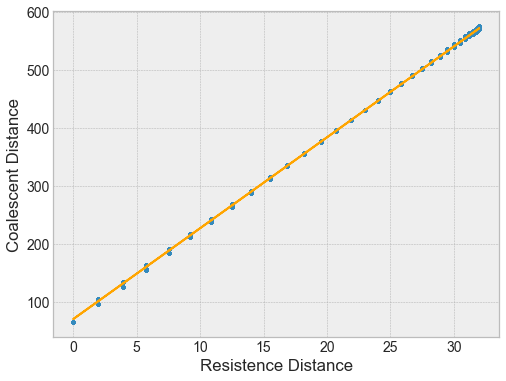

In [31]:
geno.plot_dist(d_res_tril, d_coal_tril, "Resistence Distance", "Coalescent Distance")

As expected the coalescent distance is exactly the resistance distance! 

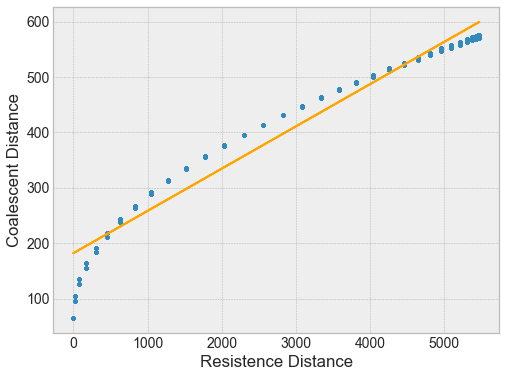

In [32]:
geno.plot_dist(d_rw_tril, d_coal_tril, "Resistence Distance", "Coalescent Distance")